# Preamble

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dask.array
import cartopy.crs as ccrs
import matplotlib.colors as colors
import datetime as dt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

import calendar
import sys
from importlib import reload
sys.path.append('/home/563/ab2313/MJO/functions')
import load_dataset as load
import subphase_calc_functions as subphase_calc
import access_functions as af

In [2]:
import access_general_functions as access_general

In [3]:
import accuracy_plots as acc_plot

In [4]:
import access_correlation_functions as access_corr

In [5]:
load = reload(load)
awap, access, rmm_obs, rmm_access = load.load_accessifies_variables()

4159 4159
4159 4159


# Large Amplitude

In [10]:
std = np.std(rmm_obs.amplitude.values)
mean = np.mean(rmm_obs.amplitude.values)

In [26]:
large_amp = rmm_obs.where(rmm_obs.amplitude > 1, drop = True)
large_amp

<xarray.Dataset>
Dimensions:    (time: 2691)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2012-12-31
Data variables:
    RMM1       (time) float64 0.4753 0.5313 0.6849 ... 0.03834 -0.00368 0.6692
    RMM2       (time) float64 -1.637 -1.748 -1.818 ... -1.028 -1.027 -0.9496
    phase      (time) float64 3.0 3.0 3.0 3.0 3.0 3.0 ... 1.0 1.0 3.0 2.0 3.0
    amplitude  (time) float64 1.705 1.827 1.942 1.982 ... 1.029 1.027 1.162

In [27]:
lai = large_amp.where(large_amp.time.dt.day == 1, drop = True)
lai

<xarray.Dataset>
Dimensions:    (time: 87)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2012-10-01
Data variables:
    RMM1       (time) float64 0.4753 -0.7697 1.797 0.4381 ... 1.084 0.4861 1.247
    RMM2       (time) float64 -1.637 1.517 -0.9674 -1.702 ... 1.664 -1.883 1.497
    phase      (time) float64 3.0 7.0 4.0 3.0 7.0 7.0 ... 4.0 6.0 6.0 3.0 6.0
    amplitude  (time) float64 1.705 1.701 2.041 1.757 ... 1.42 1.986 1.945 1.948

In [28]:
lai.time.values

array(['1990-01-01T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-03-01T00:00:00.000000000', '1990-11-01T00:00:00.000000000',
       '1990-12-01T00:00:00.000000000', '1991-03-01T00:00:00.000000000',
       '1991-12-01T00:00:00.000000000', '1992-02-01T00:00:00.000000000',
       '1992-03-01T00:00:00.000000000', '1992-11-01T00:00:00.000000000',
       '1992-12-01T00:00:00.000000000', '1993-01-01T00:00:00.000000000',
       '1993-02-01T00:00:00.000000000', '1993-11-01T00:00:00.000000000',
       '1993-12-01T00:00:00.000000000', '1994-02-01T00:00:00.000000000',
       '1994-03-01T00:00:00.000000000', '1994-10-01T00:00:00.000000000',
       '1994-11-01T00:00:00.000000000', '1994-12-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '1995-03-01T00:00:00.000000000',
       '1995-11-01T00:00:00.000000000', '1995-12-01T00:00:00.000000000',
       '1996-02-01T00:00:00.000000000', '1996-03-01T00:00:00.000000000',
       '1996-11-01T00:00:00.000000000', '1997-01-01

# Count

## Calculation

In [3]:
subphase_calc = reload(subphase_calc)
# Split AWAP into the subphases: enhanced, suppressed, transition and inactive.
awap_split = subphase_calc.split_into_subphase(awap, rmm_obs)

In [4]:
subphase_calc = reload(subphase_calc)
# Split access into the subphases: enhanced, suppressed, transition and inactive.
access_split = af.access_rmm_split(access, rmm_access)

1 2 3 4 5 6 7 8 9 10 11 

In [6]:
access_general = reload(access_general)
rmm_count_obs  = access_general.count_in_rmm_subphase_year_month_resample(rmm_obs)

In [9]:
access_corr = reload(access_corr)
count_anom = access_corr.count_month_year_anomalies(awap_split, awap, rmm_count_obs)

In [10]:
access_general = reload(access_general)
access_corr = reload(access_corr)
count_anom_ens, count_anom_ens_med = \
                access_general.access_ensemble_calculation(access_split, access, rmm_access,
                                                           access_corr.count_month_year_anomalies)

In [11]:
count_anom

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * lat      (lat) float64 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float64 113.8 114.0 114.2 114.5 ... 150.0 150.2 150.5 150.8
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
  * month    (month) int64 1 2 3 10 11 12
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
Data variables:
    precip   (month, year, phase, lat, lon) float64 nan 1.761 1.761 ... nan nan

In [12]:
count_anom_ens_med

<xarray.Dataset>
Dimensions:  (lat: 49, lon: 149, month: 6, phase: 4, year: 23)
Coordinates:
  * lat      (lat) float32 -23.0 -22.75 -22.5 -22.25 ... -11.5 -11.25 -11.0
  * lon      (lon) float32 113.75 114.0 114.25 114.5 ... 150.25 150.5 150.75
  * month    (month) int64 1 2 3 10 11 12
  * phase    (phase) object 'enhanced' 'suppressed' 'transition' 'inactive'
  * year     (year) int64 1990 1991 1992 1993 1994 ... 2008 2009 2010 2011 2012
Data variables:
    precip   (month, year, phase, lat, lon) float64 nan 0.1615 ... nan nan

In [70]:
obs = count_anom
mod = count_anom_ens_med

# Getting just th emodel where awap has rain and vice-verse
mod.where(np.isfinite(obs.precip.values))
obs.where(np.isfinite(mod.precip.values))

max_score = obs.count(dim = 'year')

correct_neg = obs.where(np.logical_and(obs.precip < 1,mod.precip < 1)) # Both model and observations are reduced anomaly
correct_pos = obs.where(np.logical_and(obs.precip > 1,mod.precip > 1)) # Both are positive anomalies

score = correct_neg.count(dim = 'year') + correct_pos.count(dim = 'year')

percent = score * 100 /max_score

In [65]:
obs_tot = count_anom
mod_tot = count_anom_ens_med

month_groups = [[10,11,12],[1,2,3]]
month_stor = []
for months in month_groups:
    obs = obs_tot.sel(month = months)
    mod = mod_tot.sel(month = months)

    # Getting just th emodel where awap has rain and vice-verse
    mod = mod.where(np.isfinite(obs.precip.values))
    obs = obs.where(np.isfinite(mod.precip.values))

    max_score = obs.count(dim = 'year').sum(dim = 'month')
    # Both model and observations are reduced anomaly
    correct_neg = obs.where(np.logical_and(obs.precip < 1,mod.precip < 1))
    # Both are positive anomalies
    correct_pos = obs.where(np.logical_and(obs.precip > 1,mod.precip > 1))  
    
    #Adding together the scores
    score = correct_neg.count(dim = 'year') + correct_pos.count(dim = 'year')
    # Summing acorss month, to get the values for early and late wet season
    score = score.sum(dim = 'month')
    
    # The percent of scores that are correct
    percent = score * 100 /max_score
    month_stor.append(percent)
accuracy_count_2div = xr.concat(month_stor, pd.Index(['early','late'], name = 'month'))

In [72]:
savedir = 'plots_3/accuracy/'

## Plots

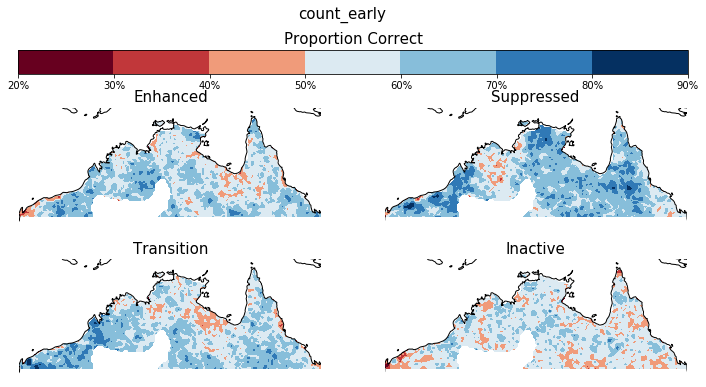

In [84]:
acc_plot = reload(acc_plot)
month = 'early'
savetitle = f'count_{month}'
acc_plot.accuracy_plot(accuracy_count_2div.sel(month = month), vmin = 20, vmax = 90, 
                       savetitle = savetitle, savedir = savedir)

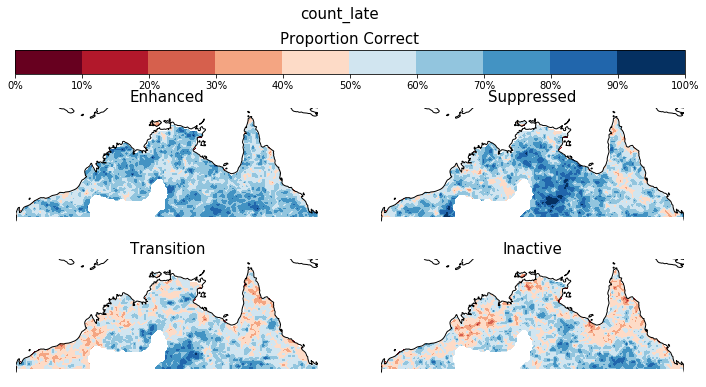

In [83]:
acc_plot = reload(acc_plot)
month = 2
save_title = f'count_{calendar.month_name[month]}'

acc_plot.accuracy_plot(percent.sel(month = month), vmin = 0, vmax = 100, 
                       savetitle = savetitle, savedir = savedir)